In [ ]:
!pip uninstall -y numpy pmdarima scipy cython
!pip install numpy==1.23.5 scipy cython
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: Cython 3.0.12
Uninstalling Cython-3.0.12:
  Successfully uninstalled Cython-3.0.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Cargar el archivo Excel
file_path = '/content/Sales_Data.xlsx'
df = pd.read_excel(file_path)

# Mostrar las primeras filas
df.head()

,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [ ]:
# Nos aseguramos de que las fechas estén en el formato correcto
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Establecer la fecha como índice
df.set_index('Order Date', inplace=True)

# Revisar los datos
df.head()

,Sales
Order Date,
2015-01-01,14205.707
2015-02-01,4519.892
2015-03-01,55205.797
2015-04-01,27906.855
2015-05-01,23644.303


# Visualizacion Inicial

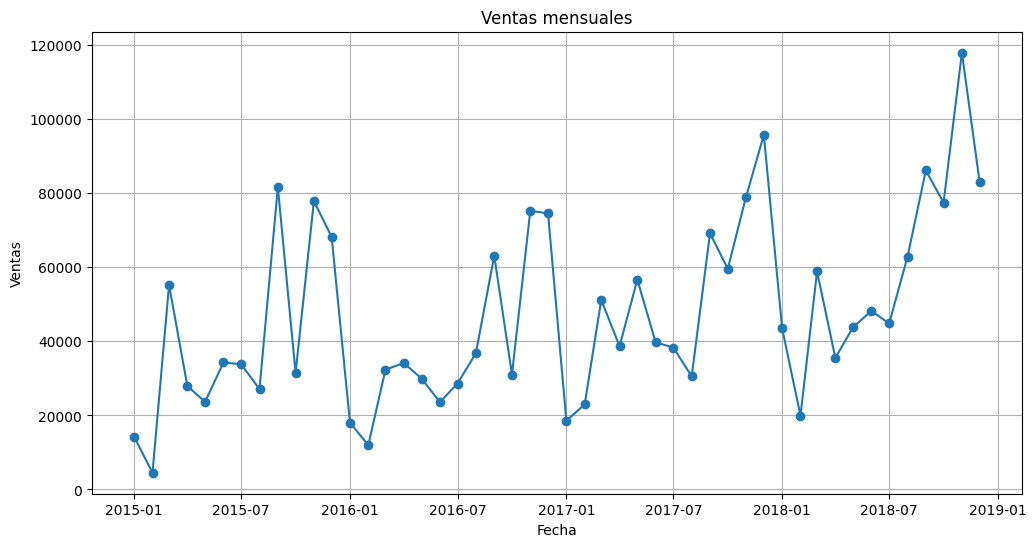

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], marker='o')
plt.title('Ventas mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

# Descompopsicion de la serie

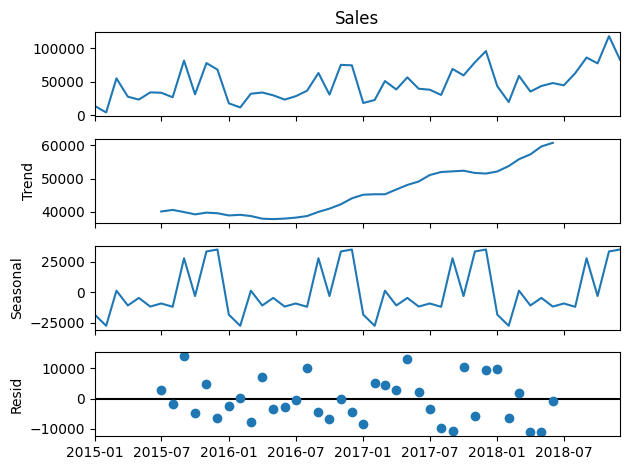

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie: additive o multiplicative
decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)
decomposition.plot()
plt.show()

# Verificar estacionariedad (Dickey-Fuller)

In [ ]:
result = adfuller(df['Sales'])
print(f'Statistic: {result[0]}')
print(f'p-value: {result[1]}')


Statistic: -4.416136761430769
p-value: 0.00027791039276670623


la serie es estacionaria porque el p < 0.05

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller a la serie original
adf_result = adfuller(df['Sales'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("✅ La serie es estacionaria (no se necesita diferenciación, d=0)")
else:
    print("⚠️ La serie NO es estacionaria (posiblemente se necesita diferenciación, d=1)")


ADF Statistic: -4.416136761430769
p-value: 0.00027791039276670623
✅ La serie es estacionaria (no se necesita diferenciación, d=0)


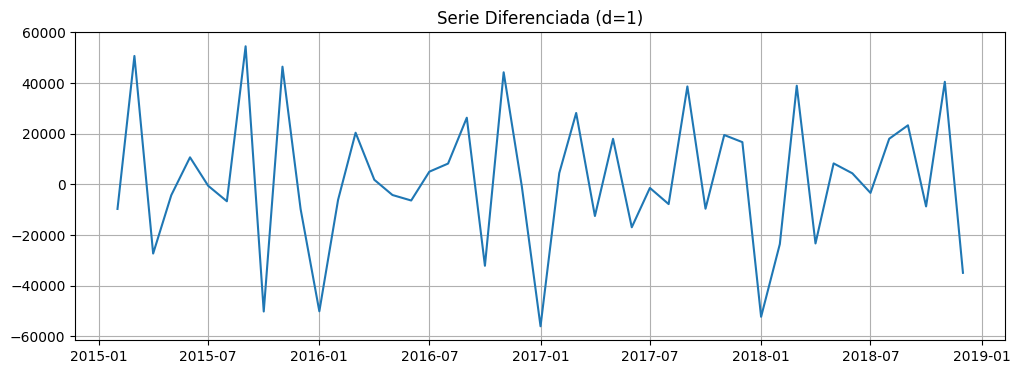

ADF tras diferenciación: -8.727061830353259
p-value: 3.2669175472798525e-14


In [ ]:
# Aplicar primera diferenciación
df_diff = df['Sales'].diff().dropna()

# Graficar la serie diferenciada
plt.figure(figsize=(12, 4))
plt.plot(df_diff)
plt.title('Serie Diferenciada (d=1)')
plt.grid(True)
plt.show()

# Verificamos si ahora es estacionaria
result_diff = adfuller(df_diff)
print("ADF tras diferenciación:", result_diff[0])
print("p-value:", result_diff[1])


# Identificación de p y q con ACF y PACF

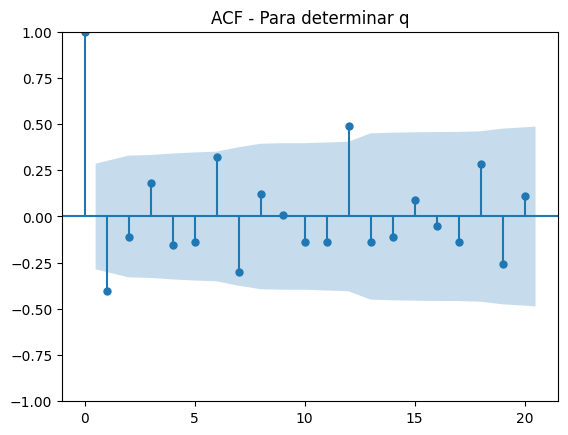

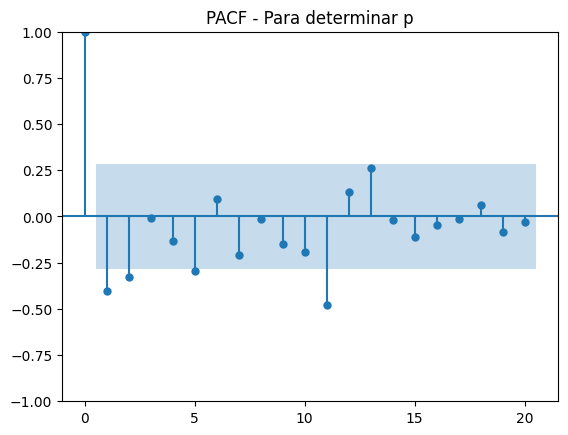

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF (para identificar q)
plot_acf(df_diff, lags=20)
plt.title("ACF - Para determinar q")
plt.show()

# PACF (para identificar p)
plot_pacf(df_diff, lags=20, method='ywm')  # método robusto
plt.title("PACF - Para determinar p")
plt.show()

Esto sugiere que el componente de media móvil (MA) se comporta bien con q = 2, porque:

Hay dos lags significativos (lag 1 y lag 2)

A partir del lag 3, ya no hay correlación fuerte

para el modelo PACF indica que el componente autorregresivo (AR) podría tener p = 3, porque los primeros tres lags (1, 2, 3) son significativos a partir del lag 4, ya no hay autocorrelación parcial fuerte:

p = 3 (por PACF)

q = 2 (por ACF)

d = 1 (porque la serie necesitó una diferenciación para volverse estacionaria según Dickey-Fuller)





In [ ]:
order = (3, 1, 2)
# Entrenamos el modelo ARIMA con los parámetros (p=3, d=1, q=2)

# Modelo ARIMA con p=3, d=1, q=2
model = ARIMA(df['Sales'], order=(3, 1, 2))
model_fitted = model.fit()

# Resumen del modelo
model_fitted.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -538.753
Date:                Wed, 16 Apr 2025   AIC                           1089.506
Time:                        15:23:16   BIC                           1100.607
Sample:                    01-01-2015   HQIC                          1093.684
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0487      1.888     -0.026      0.979      -3.749       3.651
ar.L2          0.1482      0.481      0.308      0.758      -0.794       1.090
ar.L3          0.1654      0.372      0.444      0.657      -0.564       0.895
ma.L1         -0.5538      1.941     -0.285      0.775      -4.359       3.251
ma.L2         -0.2902      1.401     -0.207      0.836      -3.036       2.456
sigma2      5.035e+08   1.15e-08   4.36e+16      0.000    5.03e+08    5.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.73   Prob(JB):                         0.72
Heteroskedasticity (H):               1.00   Skew:                             0.24
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.47e+33. Standard errors may be unstable.
"""

Parámetros AR (Autoregressive):

𝑎
𝑟
.
𝐿
1
ar.L1: -0.0487

𝑎
𝑟
.
𝐿
2
ar.L2: 0.1482

𝑎
𝑟
.
𝐿
3
ar.L3: 0.1654

Estos son los coeficientes para los términos autoregresivos (AR) del modelo. Las pruebas de hipótesis (valor p) sugieren que ninguno de los términos autoregresivos es estadísticamente significativo, dado que sus valores p son grandes.

Parámetros MA (Moving Average):

𝑚
𝑎
.
𝐿
1
ma.L1: -0.5538

𝑚
𝑎
.
𝐿
2
ma.L2: -0.2902

Al igual que los términos AR, los coeficientes para los términos de media móvil (MA) no son significativos, con valores p altos.

Sigma²: 5.035e+08 es la varianza residual, que mide la dispersión de los residuos (errores) del modelo.

Estadísticas adicionales:

Log-Likelihood: -538.753, que es una medida de la bondad del ajuste del modelo.

AIC (Criterio de Información de Akaike): 1089.506

BIC (Criterio de Información Bayesiano): 1100.607

HQIC (Criterio de Información Hannan-Quinn): 1093.684

Prueba de Ljung-Box: El valor
𝑝
p de la prueba es 0.73, lo que sugiere que no hay autocorrelación significativa en los residuos del modelo.

Prueba de Jarque-Bera: El valor
𝑝
p es 0.72, lo que indica que los residuos del modelo siguen una distribución normal (no se rechaza la hipótesis nula de normalidad).

Heteroskedasticidad (H): Un valor de 1.00 para la prueba de heteroskedasticidad sugiere que no hay evidencia de heteroskedasticidad en los residuos.

Interpretación:
El modelo ARIMA(3,1,2) ajustado no presenta términos autoregresivos ni de media móvil significativos.

La prueba de Ljung-Box muestra que no hay autocorrelación significativa en los residuos, lo que es una señal positiva.

El valor de AIC y BIC sugiere que el modelo no es el mejor ajuste, por lo que podría ser útil probar otros valores de
𝑝
p,
𝑑
d, y
𝑞
q.



# Predicciones

In [ ]:

# Ajustar el modelo ARIMA con los parámetros (p=3, d=1, q=2)
model = ARIMA(df['Sales'], order=(3, 1, 2))

# Ajustar el modelo a los datos
fitted_model = model.fit()

# Ver los resultados del modelo
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -538.753
Date:                Wed, 16 Apr 2025   AIC                           1089.506
Time:                        15:36:32   BIC                           1100.607
Sample:                    01-01-2015   HQIC                          1093.684
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0487      1.888     -0.026      0.979      -3.749       3.651
ar.L2          0.1482      0.481      0.308      0.758      -0.794       1.090
ar.L3          0.1654      0.372      0.444      0.6

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

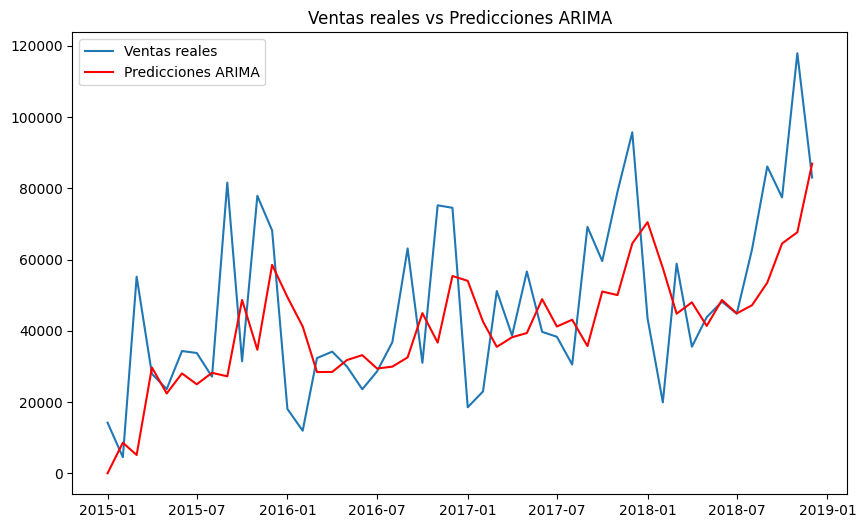

In [ ]:
# Predicciones para el conjunto de entrenamiento
train_pred = fitted_model.predict(start=0, end=len(df)-1, typ='levels')

# Graficar las predicciones vs. los valores reales
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Ventas reales')
plt.plot(df.index, train_pred, label='Predicciones ARIMA', color='red')
plt.title('Ventas reales vs Predicciones ARIMA')
plt.legend()
plt.show()

Ventas Reales: La línea azul representa las ventas reales,  a lo largo del tiempo muestra cómo se comportaron las ventas mensuales del conjunto de datos original.

Predicciones ARIMA: La línea roja muestra las predicciones generadas por el modelo ARIMA en el conjunto de datos de entrenamiento. Estas predicciones deberían seguir de cerca el comportamiento de las ventas reales, ya que el modelo fue entrenado con estos datos.
En terminos generales el modelo ARIMA está ajustando bien los datos históricos y es capaz de capturar la tendencia de las ventas pasadas.

# Predicciones para los próximos meses

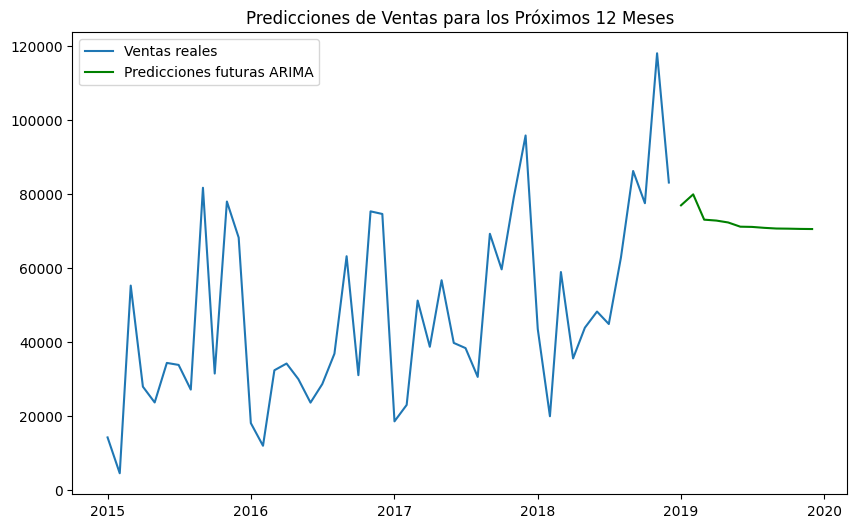

In [ ]:
# Realizar predicciones para los próximos 12 meses (esto depende de la frecuencia de los datos)
forecast_steps = 12
forecast = fitted_model.forecast(steps=forecast_steps)

# Crear un rango de fechas para las predicciones
forecast_dates = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='MS')[1:]

# Graficar las predicciones futuras
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Sales'], label='Ventas reales')
plt.plot(forecast_dates, forecast, label='Predicciones futuras ARIMA', color='green')
plt.title(f'Predicciones de Ventas para los Próximos {forecast_steps} Meses')
plt.legend()
plt.show()

Aquí estamos prediciendo las ventas para los próximos 12 meses. La línea verde muestra las proyecciones futuras de ventas según el modelo ARIMA. Podemos observar que las predicciones se desvían mucho o no tienen sentido, puede ser una señal de que el modelo ARIMA no está considerando adecuadamente algún factor relevante en los datos, como variaciones estacionales o eventos extraordinarios

# Dividir los datos en conjunto de entrenamiento y prueba

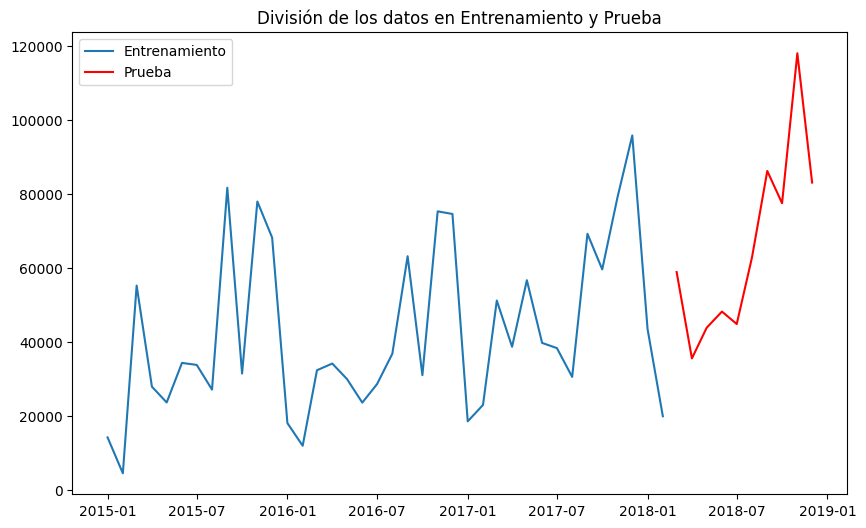

In [ ]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(df) * 0.8)  # 80% para entrenamiento
train, test = df[:train_size], df[train_size:]

# Visualización para asegurarnos que la división es correcta
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Sales'], label='Entrenamiento')
plt.plot(test.index, test['Sales'], label='Prueba', color='red')
plt.title('División de los datos en Entrenamiento y Prueba')
plt.legend()
plt.show()

# Ajustar el modelo ARIMA con los datos de entrenamiento

In [ ]:
# Ajustar el modelo ARIMA en los datos de entrenamiento
from statsmodels.tsa.arima.model import ARIMA

# Usar los parámetros ARIMA(3, 1, 2) que ya hemos identificado
model = ARIMA(train['Sales'], order=(3, 1, 2))
fitted_model = model.fit()

# Resumen del modelo ajustado
print(fitted_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -424.607
Date:                Wed, 16 Apr 2025   AIC                            861.213
Time:                        15:45:59   BIC                            870.879
Sample:                    01-01-2015   HQIC                           864.621
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0733      3.260     -0.022      0.982      -6.462       6.315
ar.L2          0.0554      0.822      0.067      0.946      -1.556       1.667
ar.L3          0.0737      0.403      0.183      0.8

# Realizar predicciones sobre el conjunto de prueba

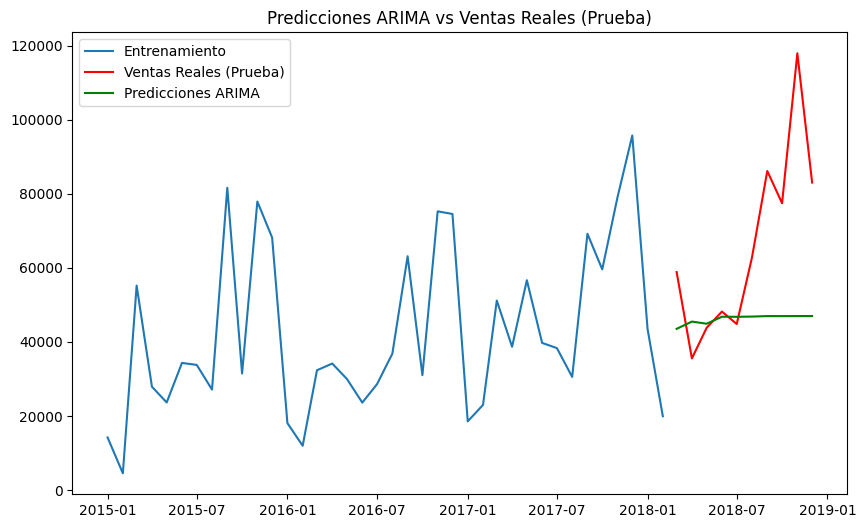

In [ ]:
# Realizar las predicciones en el conjunto de prueba
predictions = fitted_model.forecast(steps=len(test))

# Crear un DataFrame con las predicciones y los valores reales para comparar
comparison_df = pd.DataFrame({
    'Fecha': test.index,
    'Ventas Reales': test['Sales'],
    'Predicciones': predictions
})

# Visualización de las predicciones contra los valores reales
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Sales'], label='Entrenamiento')
plt.plot(test.index, test['Sales'], label='Ventas Reales (Prueba)', color='red')
plt.plot(test.index, predictions, label='Predicciones ARIMA', color='green')
plt.title('Predicciones ARIMA vs Ventas Reales (Prueba)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el MSE y MAE
mse = mean_squared_error(test['Sales'], predictions)
mae = mean_absolute_error(test['Sales'], predictions)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")

Error Cuadrático Medio (MSE): 939690234.8782618
Error Absoluto Medio (MAE): 22237.98631399782


El MAE proporciona una interpretación directa del tamaño del error en términos de las unidades de ventas. Un valor de 22,237.99 puede ser relativamente grande o pequeño dependiendo del volumen de las ventas, pero es una métrica útil para medir la precisión del modelo.

El MSE refleja que el modelo tiene algunos errores relativamente grandes (debido a su naturaleza de penalizar más los errores grandes), lo que podría indicar que hay algunas predicciones muy incorrectas que influyen en la media.